<a href="https://colab.research.google.com/github/Rakshithts/myprojects/blob/main/Genetic_Algorithm_Based_DNA_Sequence_Alignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#CI PROJECT

In [ ]:
import pandas as pd
import random

# Function to generate a random DNA sequence of given length
def generate_random_dna_sequence(length=10):
    return "".join(random.choices("ACGT", k=length))

# Generate 1000 random sequences
num_sequences = 1000
sequences = [generate_random_dna_sequence(10) for _ in range(num_sequences)]

# Define population size and generations (constant for all rows)
population_size = 100
generations = 200

# Create a DataFrame
df = pd.DataFrame({
    "sequence": sequences,
    "population": [population_size] * num_sequences,
    "generations": [generations] * num_sequences
})

# Save to CSV
df.to_csv("config.csv", index=False)

print("CSV file 'config.csv' generated successfully!")


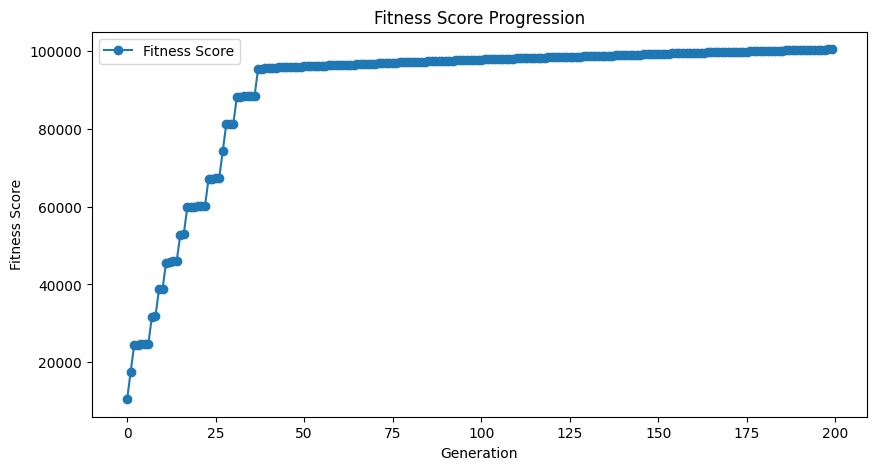

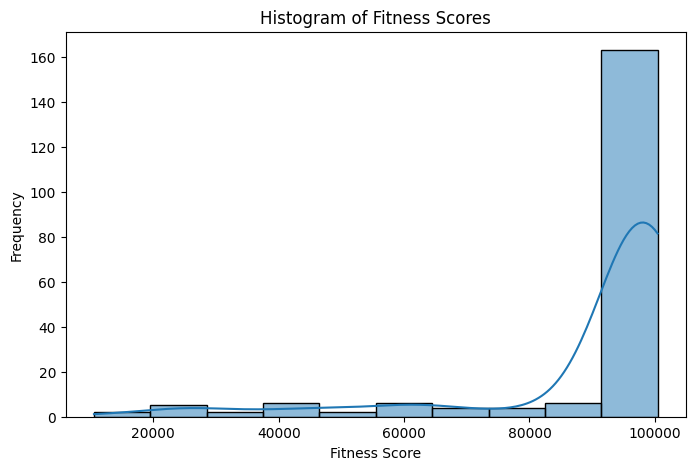

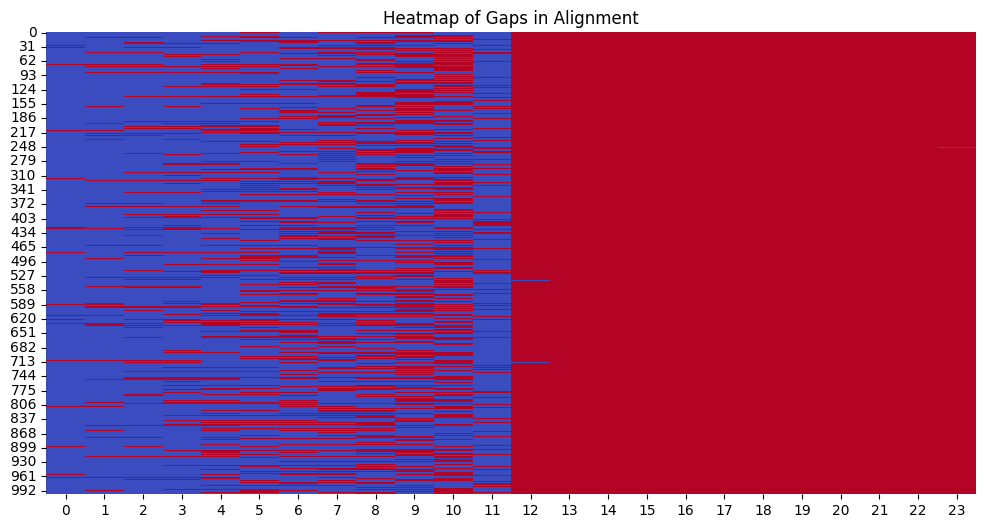

✅ Best alignment saved to 'best_alignment.csv'
Best Alignment:
GTCCT-G---GG------------
C---T--CTT-T------------
GGAAAAACTCCC------------
AATTTATTTCGC------------
GCCTTTTGTGAA------------
CCTCCC--GG-C------------
CCCCTTGGG--T------------
CCCCGG-AA--T------------
ACTCCTTTCT-G------------
CACC--GGG--A------------
Alignment Score: 100446
Accuracy Score: 71.5125 %


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scoring scheme
MATCH = 2
MISMATCH = -1
GAP_PENALTY = -2
CONSECUTIVE_GAP_PENALTY = -3  # Higher penalty for consecutive gaps

# Load sequences, population size, and generations from CSV
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path)
    sequences = df["sequence"].tolist()
    population_size = int(df["population"].iloc[0])  # Single value taken from the first row
    generations = int(df["generations"].iloc[0])  # Single value taken from the first row
    return sequences, population_size, generations

# Ensure all sequences are the same length by padding with gaps
def pad_sequences(sequences):
    max_length = max(len(seq) for seq in sequences)
    return [seq.ljust(max_length, '-') for seq in sequences]

# Generate initial population with minimal random gaps
def generate_random_alignment(sequences, max_gaps=2):
    sequences = pad_sequences(sequences)
    max_length = len(sequences[0]) + max_gaps
    aligned_sequences = []

    for seq in sequences:
        seq = list(seq)
        for _ in range(max_gaps):
            pos = random.randint(0, len(seq))
            seq.insert(pos, '-')
        aligned_sequences.append("".join(seq).ljust(max_length, '-'))
    return aligned_sequences

# Optimized fitness function using NumPy for efficiency
def fitness(alignment):
    alignment = np.array([list(seq) for seq in pad_sequences(alignment)])
    score = 0
    seq_length = alignment.shape[1]

    for i in range(seq_length):
        column = alignment[:, i]
        unique, counts = np.unique(column, return_counts=True)
        gap_count = counts[unique == '-'][0] if '-' in unique else 0
        most_common = np.max(counts) if len(counts) > 0 else 0
        consecutive_gaps = np.sum([1 for j in range(len(column)-1) if column[j] == column[j+1] == '-'])
        score += (most_common * MATCH) - (gap_count * GAP_PENALTY) - (consecutive_gaps * CONSECUTIVE_GAP_PENALTY)
    return score

# Tournament selection to maintain diversity
def tournament_selection(population, k=3):
    selected = random.sample(population, k)
    return max(selected, key=fitness)

# Two-point crossover
def crossover(parent1, parent2):
    length = min(len(parent1[0]), len(parent2[0]))
    point1, point2 = sorted(random.sample(range(1, length - 1), 2))
    child1 = [p1[:point1] + p2[point1:point2] + p1[point2:] for p1, p2 in zip(parent1, parent2)]
    child2 = [p2[:point1] + p1[point1:point2] + p2[point2:] for p1, p2 in zip(parent1, parent2)]
    return child1, child2

# Gap-aware mutation
def mutate(alignment, mutation_rate=0.05, max_gaps=1):
    mutated_alignment = []
    for sequence in alignment:
        seq_list = list(sequence)
        if random.random() < mutation_rate:
            pos = random.randint(0, len(seq_list) - 1)
            if seq_list[pos] != '-':  # Avoid excessive gaps
                seq_list.insert(pos, '-')
                if seq_list.count('-') > max_gaps:
                    seq_list.remove('-')
        mutated_alignment.append("".join(seq_list))
    return pad_sequences(mutated_alignment)

# Optimized Genetic Algorithm with Elitism
def genetic_algorithm(sequences, population_size, generations, elitism=0.1):
    sequences = pad_sequences(sequences)
    population = [generate_random_alignment(sequences) for _ in range(population_size)]
    elite_size = int(population_size * elitism)
    fitness_history = []

    for _ in range(generations):
        population = sorted(population, key=fitness, reverse=True)
        fitness_history.append(fitness(population[0]))
        new_population = population[:elite_size]  # Preserve elites

        while len(new_population) < population_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([mutate(child1), mutate(child2)])

        population = new_population[:population_size]

    best_alignment = max(population, key=fitness)

    # Plot fitness progression
    plt.figure(figsize=(10, 5))
    plt.plot(range(generations), fitness_history, marker='o', linestyle='-', label="Fitness Score")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Score")
    plt.title("Fitness Score Progression")
    plt.legend()
    plt.show()

    # Histogram of Fitness Scores
    plt.figure(figsize=(8, 5))
    sns.histplot(fitness_history, bins=10, kde=True)
    plt.xlabel("Fitness Score")
    plt.ylabel("Frequency")
    plt.title("Histogram of Fitness Scores")
    plt.show()

    # Heatmap of Alignment
    alignment_array = np.array([list(seq) for seq in best_alignment])
    plt.figure(figsize=(12, 6))
    sns.heatmap(alignment_array == '-', cmap='coolwarm', cbar=False)
    plt.title("Heatmap of Gaps in Alignment")
    plt.show()

    save_best_alignment(best_alignment, "best_alignment.csv")
    return best_alignment, fitness(best_alignment)

def save_best_alignment(alignment, file_path):
    df = pd.DataFrame({"aligned_sequence": alignment})
    df.to_csv(file_path, index=False)
    print(f"Best alignment saved to '{file_path}'")

# Accuracy Calculation
def accuracy(alignment, original_sequences):
    alignment = pad_sequences(alignment)
    original_sequences = pad_sequences(original_sequences)

    correct_matches = 0
    total_positions = 0
    max_length = max(len(alignment[0]), len(original_sequences[0]))

    for i in range(max_length):
        column = [seq[i] if i < len(seq) else '-' for seq in alignment]
        original_column = [seq[i] if i < len(seq) else '-' for seq in original_sequences]
        correct_matches += sum(1 for x, y in zip(column, original_column) if x == y)
        total_positions += len(column)

    return (correct_matches / total_positions) * 100 if total_positions > 0 else 0

# Load sequences, population size, and generations from CSV
sequences, population_size, generations = load_data_from_csv("/content/config.csv")

# Run Genetic Algorithm using loaded parameters
result, score = genetic_algorithm(sequences, population_size, generations)

# Calculate Accuracy
accuracy_score = accuracy(result, sequences)

# Display results
print("Best Alignment:")
for seq in result[:10]:  # Print only first 10 sequences for readability
    print(seq)
print("Alignment Score:", score)
print("Accuracy Score:", accuracy_score, "%")
